In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#@title imports and code from previous assignments
import numpy as np
from matplotlib import pyplot as plt
!pip install dill
import dill

class Model:
    def __init__(self):
        self.params = {}

    def predict(self, X):
        raise NotImplementedError

    def loss(self, X, y):
        raise NotImplementedError

    def grad(self, X, y):
        raise NotImplementedError

class Optimizer:
    def __init__(self, model):
        self.model = model

    def step(self, grad):
        raise NotImplementedError

class SGD(Optimizer):
    def __init__(self, model, learning_rate=1e-3):
        super().__init__(model)
        self.learning_rate = learning_rate

    def step(self, grad):
        for param in self.model.params:
            self.model.params[param] -= self.learning_rate * grad[param]

## Here's an implementation of ADAM from Jasper if you do not have one yet
class ADAM(Optimizer):
    def __init__(
        self, model: Model, lr: float = 1e-3, b1: float = 0.9, b2: float = 0.999
    ) -> None:
        super().__init__(model)
        self.lr = lr
        self.b1, self.b2 = b1, b2
        self.m1 = {param: 0.0 for param in model.params}
        self.m2 = {param: 0.0 for param in model.params}

    def step(self, grad: dict[str, np.ndarray[np.float64]]) -> None:
        for param in self.model.params:
            self.m1[param] = self.m1[param] * self.b1 + grad[param] * (1 - self.b1)
            self.m2[param] = self.m2[param] * self.b2 + grad[param] ** 2 * (1 - self.b2)
            self.model.params[param] -= (
                self.lr * self.m1[param] / np.sqrt(self.m2[param] + 1e-7)
            )

def grad_check(model, X, y, eps = 1e-6):
    """Numerically estimate the gradient of the loss function and compare it to the analytical gradient"""
    grad = model.grad(X, y)
    for param in model.params:
        print(f"Checking {param}:")
        print(f"Analytical gradient {grad[param]}")
        assert grad[param].shape == model.params[param].shape, "Gradient shape mismatch"
        numgrad = np.zeros(grad[param].shape)
        for i, val in np.ndenumerate(model.params[param]):
            model.params[param][i] = val + eps
            loss1 = model.loss(X, y)
            model.params[param][i] = val - eps
            loss2 = model.loss(X, y)
            model.params[param][i] = val
            numgrad[i] = (loss1 - loss2) / (2 * eps)
        print(f"Numerical gradient {numgrad}")
        print(f"Difference {abs(numgrad - grad[param])}")
        print()

def train(model, X_train, y_train, num_epochs = 50,
          print_every = 1,
          batch_size = None, optimizer = None,
          X_val = None, y_val = None,
          save_path='best_model.pkl'):

    if optimizer is None:
        optimizer = SGD(model)
    if batch_size is None:
        batch_size = X_train.shape[0]

    if X_val is not None:
        best_val_acc = np.mean(model.classify(X_val) == y_val)

    for epoch in range(num_epochs):

        if epoch % print_every == 0 and print_every >= 0:
            print(f"Epoch {epoch}:")
            print(f"Train Loss = {model.loss(X_train, y_train)}")
            print(f"Train Accuracy = {np.mean(model.classify(X_train) == y_train)}")
            if X_val is not None:
                print(f"Val Loss = {model.loss(X_val, y_val)}")
                val_acc = np.mean(model.classify(X_val) == y_val)
                print(f"Val Accuracy = {val_acc}")
                if val_acc > best_val_acc:
                    best_val_acc = val_acc
                    with open(save_path, 'wb') as f:
                        dill.dump(model, f)

        # split into batches and loop over batches
        indices = np.random.permutation(X_train.shape[0])
        num_batches = X_train.shape[0] // batch_size
        batch_indices = np.array_split(indices, num_batches)
        for batch in batch_indices:
            optimizer.step(model.grad(X_train[batch], y_train[batch]))

# This is my implementation of Linear Classifier
class LinearClassifier(Model):
    def __init__(self, input_dim, output_dim, reg=0):
        W = np.zeros((input_dim, output_dim))
        b = np.zeros(output_dim)
        self.params = {'W': W, 'b': b}
        self.reg = reg

    def predict(self, X):
        return X @ self.params['W'] + self.params['b']

    def classify(self, X):
        scores = self.predict(X)
        return np.argmax(scores, axis=1)

    def probs(self, X):
        scores = self.predict(X)
        scores -= np.max(scores, axis=1, keepdims=True) # numerical stability trick
        scores = np.exp(scores)
        return scores / np.sum(scores, axis=1, keepdims=True)

    def loss(self, X, y):
        # cross entropy loss
        probs = self.probs(X)
        loss = -np.log(probs[np.arange(X.shape[0]), y]).mean()
        loss += self.reg * np.sum(self.params['W'] ** 2)
        return loss

    def grad(self, X, y):
        dscores = self.probs(X)
        dscores[np.arange(X.shape[0]), y] -= 1
        dW = np.dot(X.T, dscores) / X.shape[0]
        dW += 2 * self.reg * self.params['W']
        db = np.sum(dscores, axis=0) / X.shape[0]
        grad = {'W': dW, 'b': db}
        return grad

def plot_2d_data(X, y):
    fig, ax = plt.subplots(figsize = (5, 5))
    ax.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral, edgecolors='black')

def plot_2d_classifier(X, y, classifier):
    """Makes a scatter plot of the data points and a background of what the classifier does.
    X is a (n,2) array of data points.
        y is an (n,) array of labels.
        classifier is a function that takes a 2d points
         and gives a label."""
    border = 0.2
    x_min, x_max = X[:, 0].min() - border, X[:, 0].max() + border
    y_min, y_max = X[:, 1].min() - border, X[:, 1].max() + border
    num_points = 100
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, num_points),
                        np.linspace(y_min, y_max, num_points))
    grid_points = np.c_[xx.ravel(), yy.ravel()]
    classes = classifier(grid_points)
    classes = classes.reshape(xx.shape)
    fig = plt.figure(figsize = (6,6))
    plt.contourf(xx, yy, classes, 3, cmap=plt.cm.Spectral, alpha=1)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral, edgecolors='black')
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 2.2 MB/s eta 0:00:00


## Part 1: Bring in a very nonlinear 2D dataset to defeat Linear Classifier

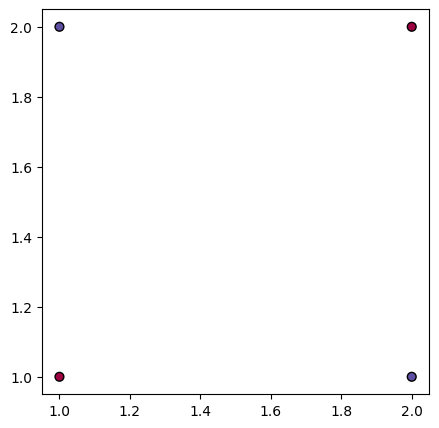

In [ ]:
X_tiny = np.array([[1,1],
                  [1,2],
                  [2,1],
                  [2,2]], dtype=float)
y_tiny = np.array([0,1,1,0])
plot_2d_data(X_tiny, y_tiny)

Epoch 0:
Train Loss = 0.6931471805599453
Train Accuracy = 0.5
Epoch 1:
Train Loss = 0.6931471805599453
Train Accuracy = 0.5
Epoch 2:
Train Loss = 0.6931471805599453
Train Accuracy = 0.5
Epoch 3:
Train Loss = 0.6931471805599453
Train Accuracy = 0.5
Epoch 4:
Train Loss = 0.6931471805599453
Train Accuracy = 0.5
Epoch 5:
Train Loss = 0.6931471805599453
Train Accuracy = 0.5
Epoch 6:
Train Loss = 0.6931471805599453
Train Accuracy = 0.5
Epoch 7:
Train Loss = 0.6931471805599453
Train Accuracy = 0.5
Epoch 8:
Train Loss = 0.6931471805599453
Train Accuracy = 0.5
Epoch 9:
Train Loss = 0.6931471805599453
Train Accuracy = 0.5
Epoch 10:
Train Loss = 0.6931471805599453
Train Accuracy = 0.5
Epoch 11:
Train Loss = 0.6931471805599453
Train Accuracy = 0.5
Epoch 12:
Train Loss = 0.6931471805599453
Train Accuracy = 0.5
Epoch 13:
Train Loss = 0.6931471805599453
Train Accuracy = 0.5
Epoch 14:
Train Loss = 0.6931471805599453
Train Accuracy = 0.5
Epoch 15:
Train Loss = 0.6931471805599453
Train Accuracy = 0.5
Ep

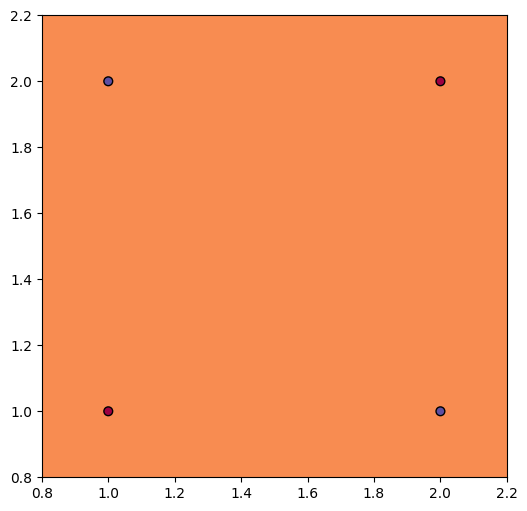

In [ ]:
classifierattempt = LinearClassifier(2,2)
train(classifierattempt, X_tiny, y_tiny)
plot_2d_classifier(X_tiny, y_tiny, classifierattempt.classify)

In [3]:
#@title Two Layer Neural Network Class

class TwoLayerNeuralNetwork(Model):
    def __init__(self, input_dim, hidden_dim, output_dim, reg=0, activationfunc="ReLU"):
        W1 = np.random.randn(input_dim, hidden_dim)/np.sqrt(input_dim)
        b1 = np.random.randn(hidden_dim)
        W2 = np.random.randn(hidden_dim, output_dim)/np.sqrt(hidden_dim)
        b2 = np.random.randn(output_dim)
        self.params = {'W1': W1, 'b1': b1, 'W2': W2, 'b2': b2}
        self.reg = reg
        self.activationfunc = activationfunc

    def activation(self,x):
        if self.activationfunc == "Sigmoid":
          return 1/(1+np.exp(-x))
        elif self.activationfunc == "LeakyReLU":
          return (x>0)*x+0.1*(x<0)*x
        else:
          return (x>0)*x

    def deactivation(self,x):
        if self.activationfunc == "Sigmoid":
          return x*(1-x)
        elif self.activationfunc == "LeakyReLU":
          return (x>0)+(x<0)*0.1
        else:
          return (x>0)

    def predict(self, X):
        return self.activation(X @ self.params['W1'] + self.params['b1']) @ self.params['W2'] + self.params['b2']

    def classify(self, X):
        scores = self.predict(X)
        return np.argmax(scores, axis=1)

    def probs(self, X):
        scores = self.predict(X)
        scores -= np.max(scores, axis=1, keepdims=True) # numerical stability trick
        scores = np.exp(scores)
        return scores / np.sum(scores, axis=1, keepdims=True)

    def loss(self, X, y):
        # cross entropy loss
        probs = self.probs(X)
        loss = -np.log(probs[np.arange(X.shape[0]), y]).mean()
        loss += self.reg * np.sum(self.params['W1'] ** 2)+self.reg * np.sum(self.params['W2'] ** 2)
        return loss

    def grad(self,X,y):

        # Output of first layer
        firstlayeroutput = self.activation(X@self.params['W1']+self.params['b1'])

        # Create output gradient
        scores = firstlayeroutput@self.params['W2']+self.params['b2']
        scores -= np.max(scores, axis=1, keepdims=True) # numerical stability trick
        scores = np.exp(scores)
        scores /= np.sum(scores, axis=1, keepdims=True)
        dscores = scores
        dscores[np.arange(X.shape[0]), y] -= 1
        outgrad = dscores/X.shape[0]

        # Create hidden layer gradient
        hiddengradient = self.deactivation(firstlayeroutput)*(outgrad@self.params['W2'].T)

        # Calculate weight gradients
        dW2 = np.dot(firstlayeroutput.T, outgrad) + 2 * self.reg * self.params['W2']
        db2 = np.sum(outgrad, axis=0)

        dW1 = np.dot(X.T, hiddengradient) + 2 * self.reg * self.params['W1']
        db1 = np.sum(hiddengradient,axis=0)

        grad = {'W1': dW1, 'b1': db1, 'W2':dW2, 'b2': db2}
        return grad



In [ ]:
# Test gradient
twolayer = TwoLayerNeuralNetwork(2,2,2,reg=0.4,activationfunc="LeakyReLU")
grad_check(twolayer, X_tiny, y_tiny)

Checking W1:
Analytical gradient [[ 1.47210406 -0.72220231]
 [ 0.0656114   0.2799897 ]]
Numerical gradient [[ 1.47210406 -0.72220231]
 [ 0.0656114   0.2799897 ]]
Difference [[3.67754716e-11 1.98577377e-10]
 [5.78098125e-11 6.66263156e-11]]

Checking b1:
Analytical gradient [ 0.10147558 -0.02364212]
Numerical gradient [ 0.10147558 -0.02364212]
Difference [6.08149642e-11 1.04051427e-10]

Checking W2:
Analytical gradient [[-0.60866269  0.5649841 ]
 [ 1.29207842 -0.28851713]]
Numerical gradient [[-0.60866269  0.5649841 ]
 [ 1.29207842 -0.28851713]]
Difference [[2.09043893e-11 2.62824207e-11]
 [1.35114142e-12 1.06624320e-10]]

Checking b2:
Analytical gradient [-0.12410145  0.12410145]
Numerical gradient [-0.12410145  0.12410145]
Difference [1.57403618e-10 1.57403604e-10]



Epoch 0:
Train Loss = 2.153142932615437
Train Accuracy = 0.5
Epoch 1:
Train Loss = 7.275981028149109
Train Accuracy = 0.5
Epoch 2:
Train Loss = 2.3448756266672333
Train Accuracy = 0.5
Epoch 3:
Train Loss = 6.601183995464068
Train Accuracy = 0.5
Epoch 4:
Train Loss = 2.432317100767337
Train Accuracy = 0.5
Epoch 5:
Train Loss = 6.000432140823126
Train Accuracy = 0.5
Epoch 6:
Train Loss = 2.4754532123499104
Train Accuracy = 0.5
Epoch 7:
Train Loss = 5.451231884566579
Train Accuracy = 0.5
Epoch 8:
Train Loss = 2.496577144275863
Train Accuracy = 0.5
Epoch 9:
Train Loss = 4.940813174896926
Train Accuracy = 0.5
Epoch 10:
Train Loss = 2.503175504353055
Train Accuracy = 0.5
Epoch 11:
Train Loss = 4.453575825490312
Train Accuracy = 0.5
Epoch 12:
Train Loss = 2.515578659399309
Train Accuracy = 0.5
Epoch 13:
Train Loss = 4.0120474962110375
Train Accuracy = 0.5
Epoch 14:
Train Loss = 2.503109229619217
Train Accuracy = 0.5
Epoch 15:
Train Loss = 3.5875932474861596
Train Accuracy = 0.5
Epoch 16:
Trai

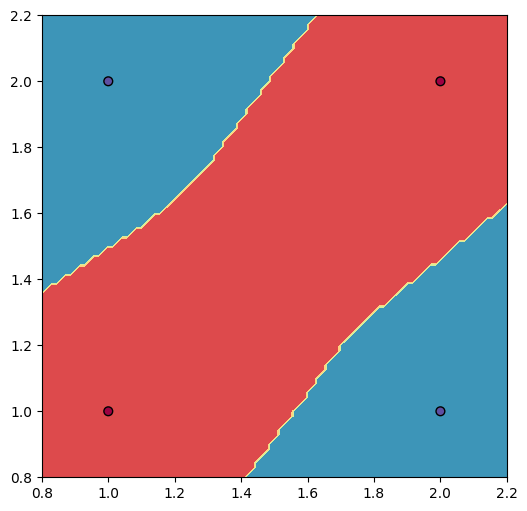

In [ ]:
#@title Train on Tiny Dataset

tinytwolayer = TwoLayerNeuralNetwork(2,100,2,activationfunc="ReLU")
train(tinytwolayer, X_tiny, y_tiny, optimizer=SGD(tinytwolayer,learning_rate=0.1), num_epochs=400)
plot_2d_classifier(X_tiny, y_tiny, tinytwolayer.classify)


In [ ]:
#@title Train on Spiral Dataset

# Spiral Dataset
def make_cluster_data(num_points = 50, noise = 0.05,
    line_points = [((1,0), (0,1)),
    ((0, 0), (-1, 1)),
    ((-1,-0.5), (1,-0.5))]):
    """Create num_points points linearly spaced between each pair of points in line_points,
    with a gaussian noise term added, where noise is the standard deviation."""
    n = num_points * len(line_points)
    points = np.zeros((n, 2))
    labels = np.zeros(n, dtype=int)
    for y in range(len(line_points)):
        for x in range(0, num_points):
            points[y*num_points+x,0]=(line_points[y][1][0]-line_points[y][0][0])*(x/(num_points-1.0))+line_points[y][0]                    [0]+np.random.normal(0,noise)
            points[y*num_points+x,1]=(line_points[y][1][1]-line_points[y][0][1])*(x/(num_points-1.0))+line_points[y][0]            [1]+np.random.normal(0,noise)
            labels[y*num_points+x]=y
    return points, labels


def make_spiral_data(num_points, num_classes):
    """Generate spiral data."""
    line_points = []
    for x in range(num_classes):
        line_points.append([(x*2*np.pi/num_classes,0),(x*2*np.pi/num_classes+np.pi*1.25,2)])
    store = make_cluster_data(num_points, 0.2, line_points)
    lines = store[0]
    for x in range(num_points*len(line_points)):
        currx = lines[x,0]
        curry = lines[x,1]
        lines[x,0]=np.cos(-currx)*curry
        lines[x,1]=np.sin(-currx)*curry
    store[1][store[1] >= 2] += store[1][store[1] >= 2]
    return lines,store[1]

spiral_dataset = make_spiral_data(50, 3)
spiralindices = np.arange(len(spiral_dataset[0]))
np.random.shuffle(spiralindices)

X_train_spiral = spiral_dataset[0][spiralindices[:int(0.8*len(spiralindices))]]
y_train_spiral = spiral_dataset[1][spiralindices[:int(0.8*len(spiralindices))]]
X_val_spiral = spiral_dataset[0][spiralindices[int(0.8*len(spiralindices)):]]
y_val_spiral = spiral_dataset[1][spiralindices[int(0.8*len(spiralindices)):]]
y_train_spiral[y_train_spiral>=4] //= 2
y_val_spiral[y_val_spiral>=4] //= 2


Reg=0 Hidden=10 Activation=Sigmoid
Train Accuracy: 0.8416666666666667
Val Accuracy: 0.9333333333333333


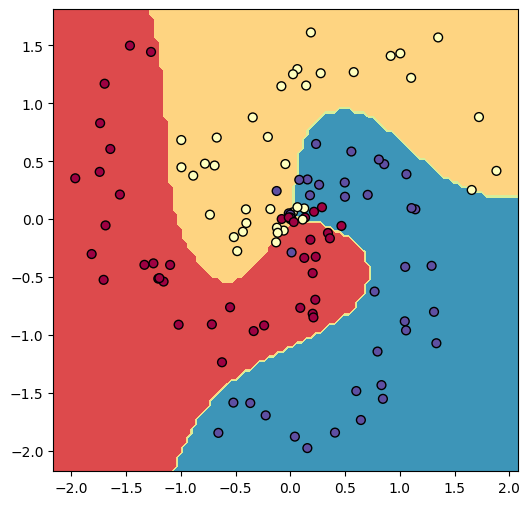

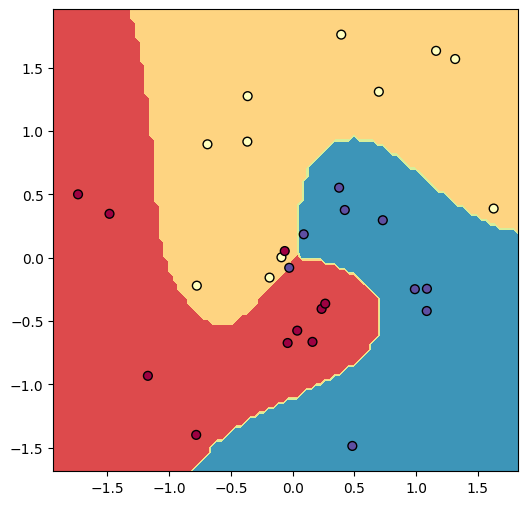


Reg=0.002 Hidden=10 Activation=Sigmoid
Train Accuracy: 0.6083333333333333
Val Accuracy: 0.5666666666666667


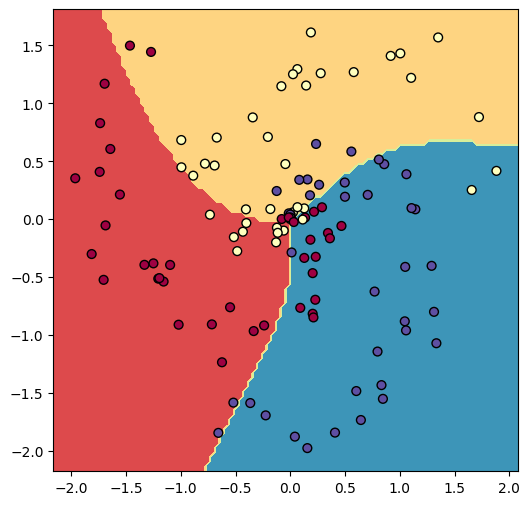

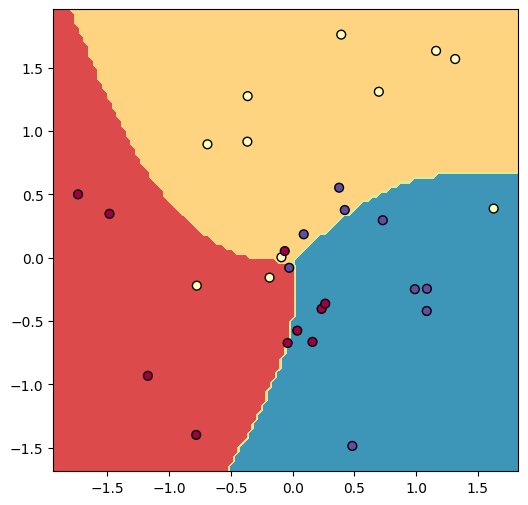


Reg=0.004 Hidden=10 Activation=Sigmoid
Train Accuracy: 0.55
Val Accuracy: 0.5666666666666667


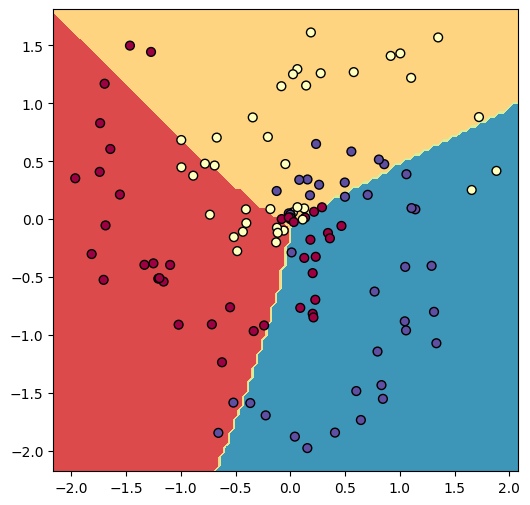

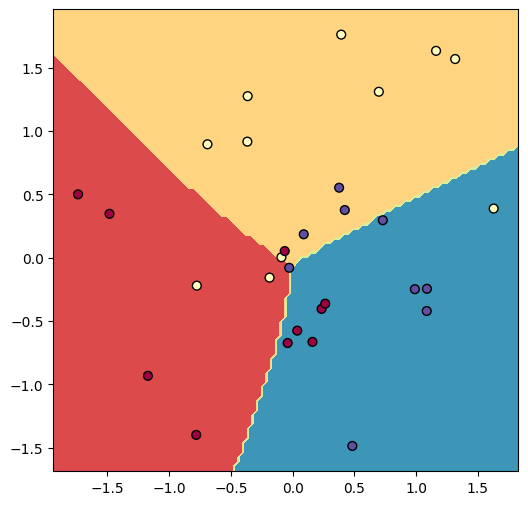


Reg=0 Hidden=20 Activation=Sigmoid
Train Accuracy: 0.8583333333333333
Val Accuracy: 0.9333333333333333


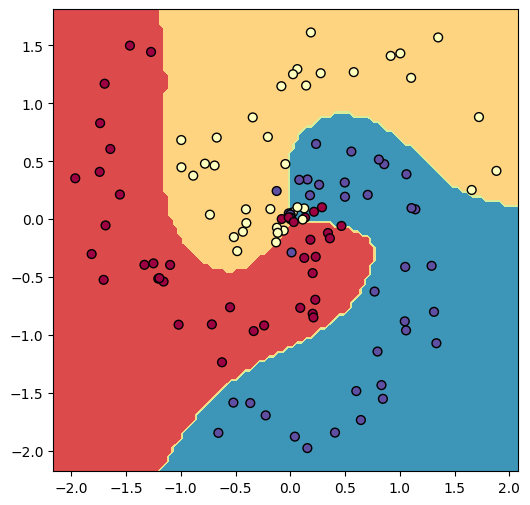

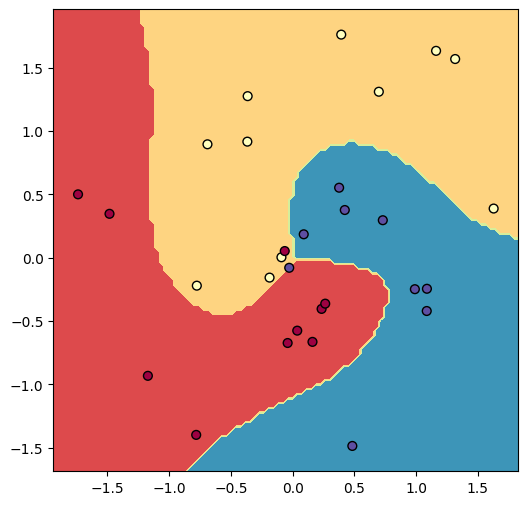


Reg=0.002 Hidden=20 Activation=Sigmoid
Train Accuracy: 0.625
Val Accuracy: 0.5666666666666667


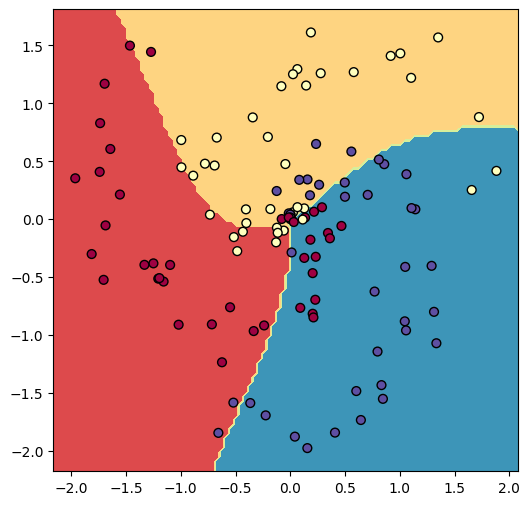

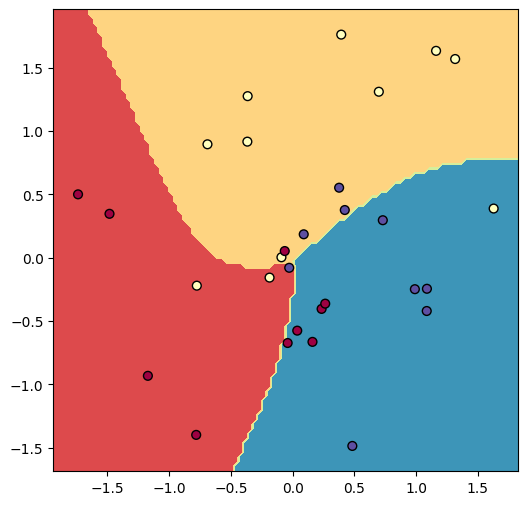


Reg=0.004 Hidden=20 Activation=Sigmoid
Train Accuracy: 0.55
Val Accuracy: 0.5666666666666667


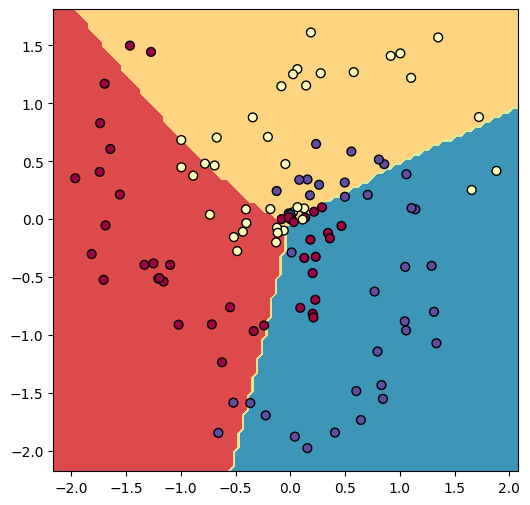

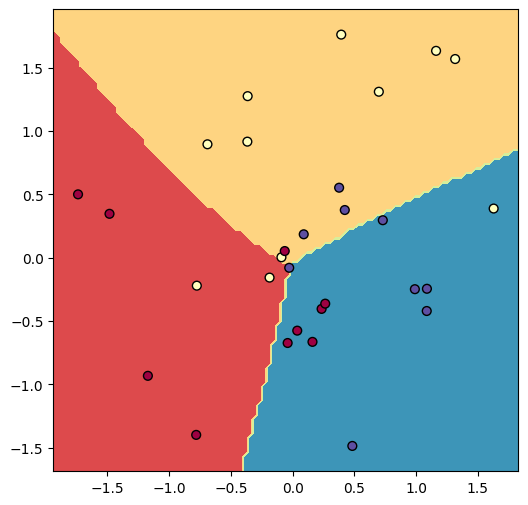


Reg=0 Hidden=30 Activation=Sigmoid
Train Accuracy: 0.8666666666666667
Val Accuracy: 0.9333333333333333


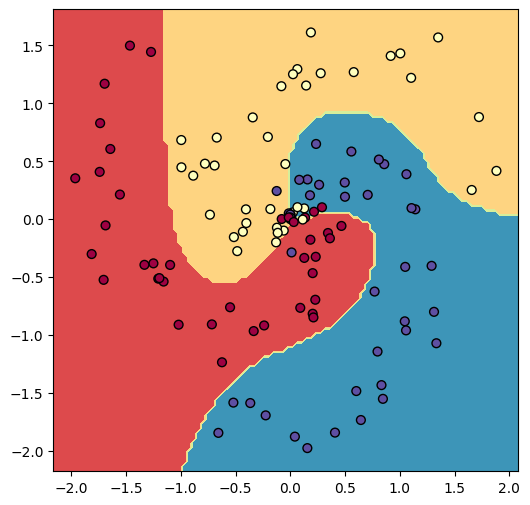

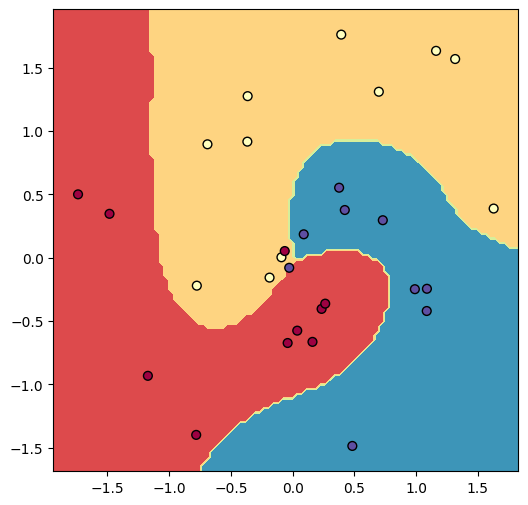


Reg=0.002 Hidden=30 Activation=Sigmoid
Train Accuracy: 0.6583333333333333
Val Accuracy: 0.6


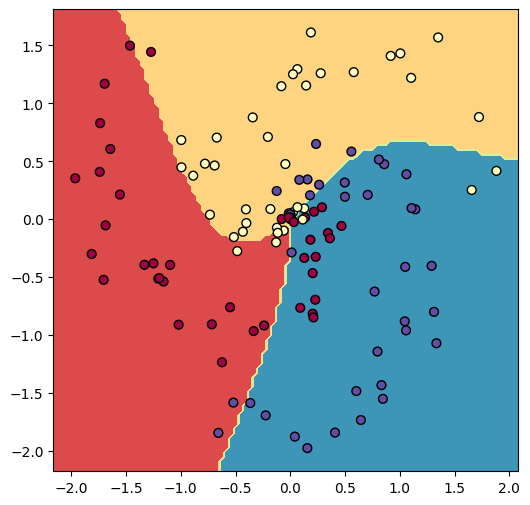

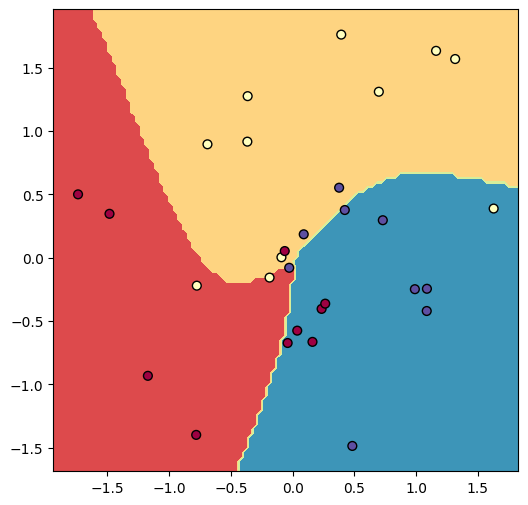


Reg=0.004 Hidden=30 Activation=Sigmoid
Train Accuracy: 0.55
Val Accuracy: 0.5666666666666667


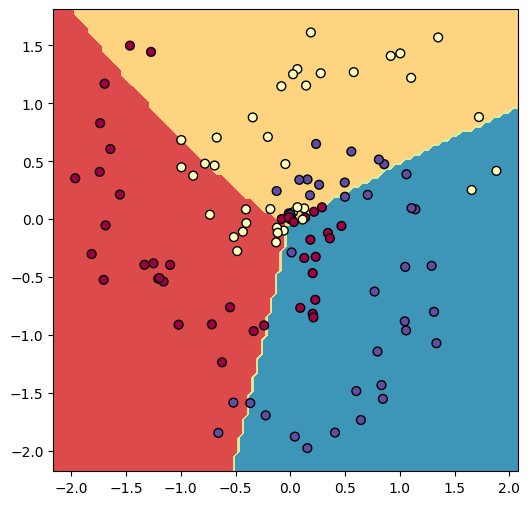

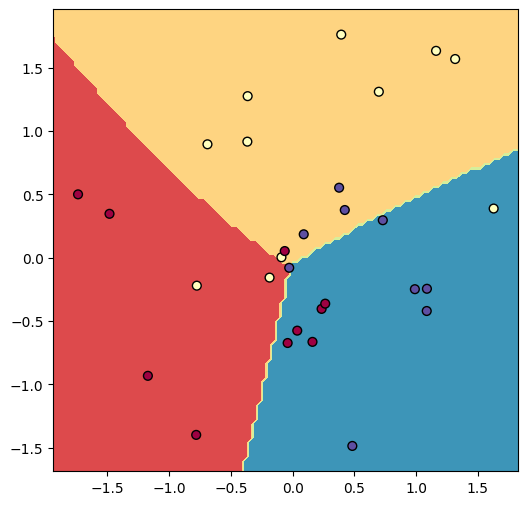


Reg=0 Hidden=10 Activation=ReLU
Train Accuracy: 0.85
Val Accuracy: 0.9


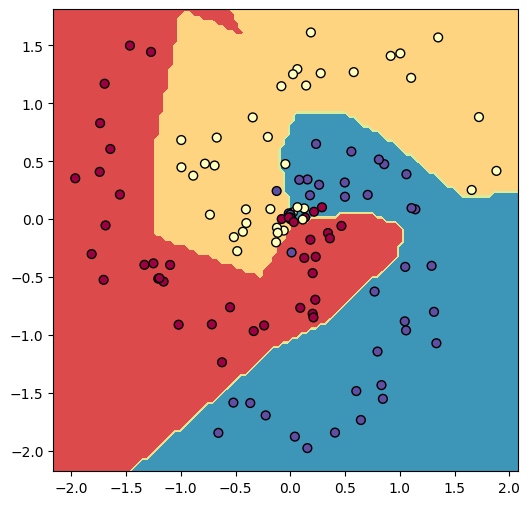

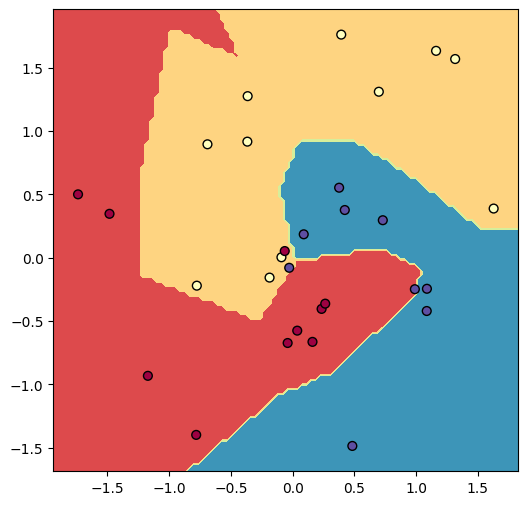


Reg=0.002 Hidden=10 Activation=ReLU
Train Accuracy: 0.825
Val Accuracy: 0.9


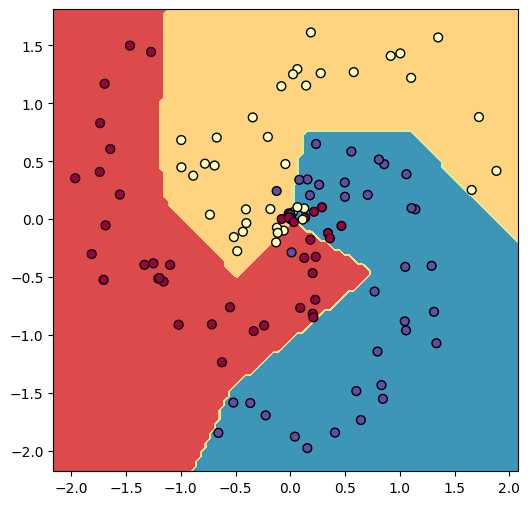

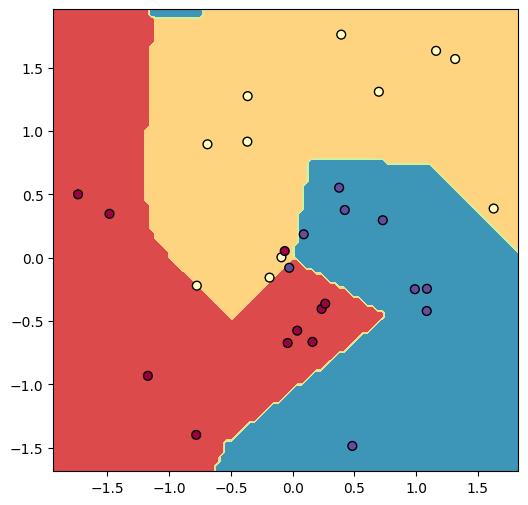


Reg=0.004 Hidden=10 Activation=ReLU
Train Accuracy: 0.8166666666666667
Val Accuracy: 0.9


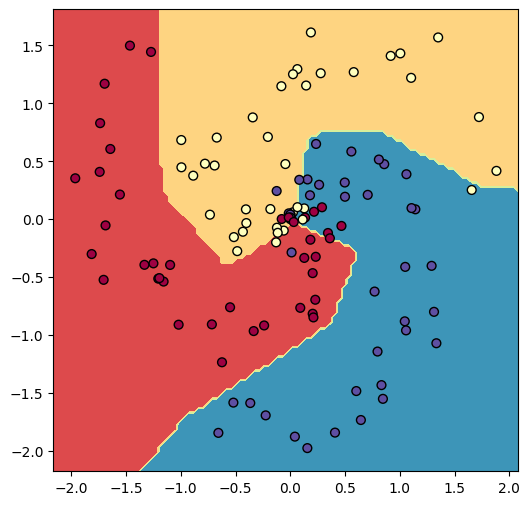

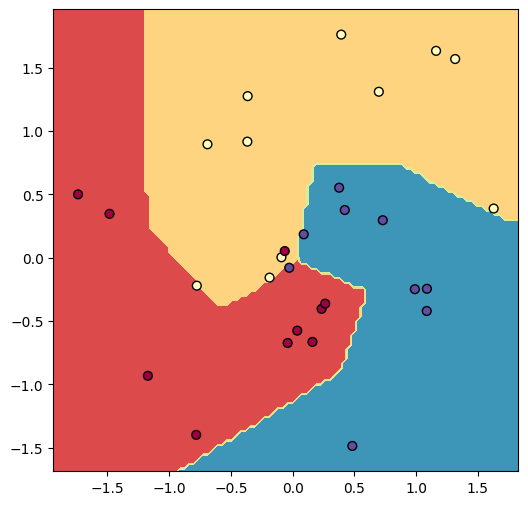


Reg=0 Hidden=20 Activation=ReLU
Train Accuracy: 0.8666666666666667
Val Accuracy: 0.9333333333333333


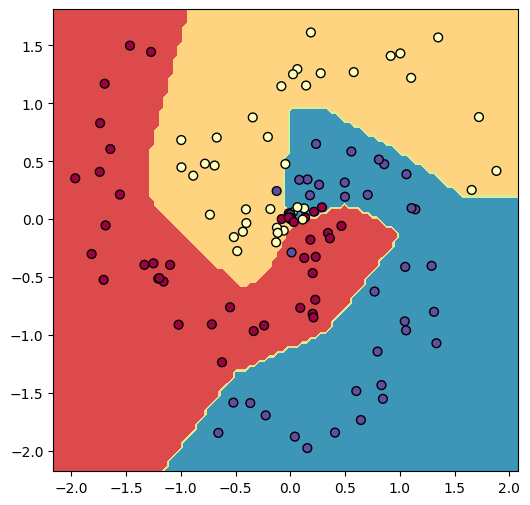

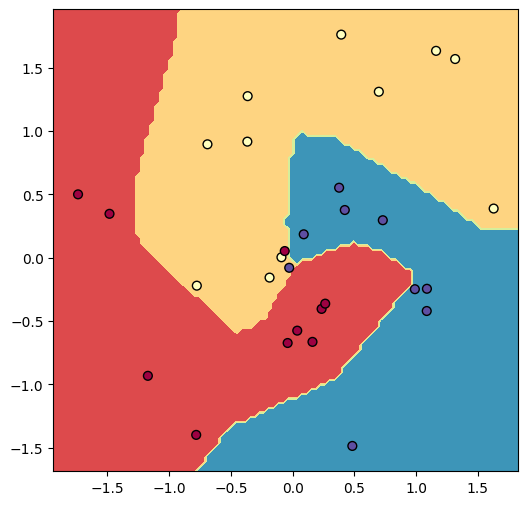


Reg=0.002 Hidden=20 Activation=ReLU
Train Accuracy: 0.85
Val Accuracy: 0.9333333333333333


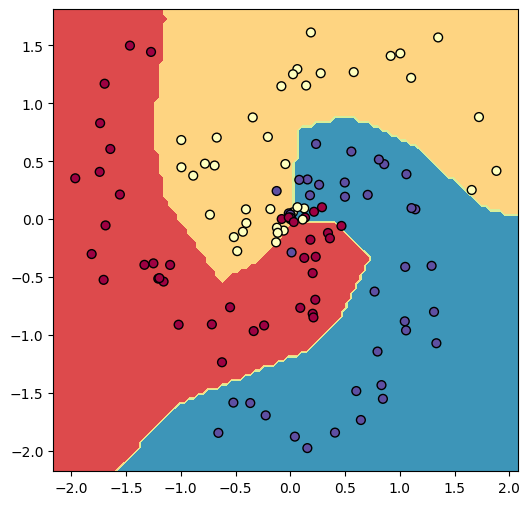

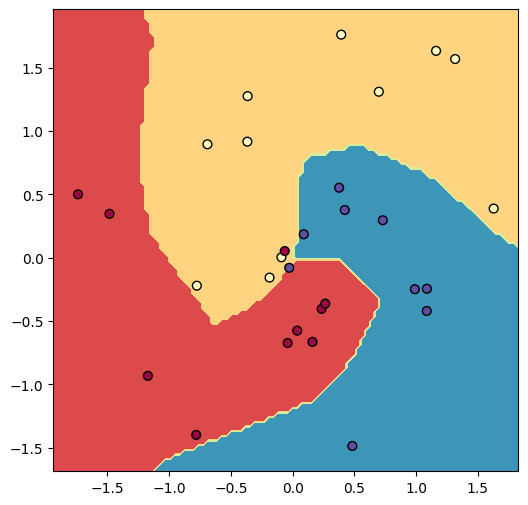


Reg=0.004 Hidden=20 Activation=ReLU
Train Accuracy: 0.825
Val Accuracy: 0.9


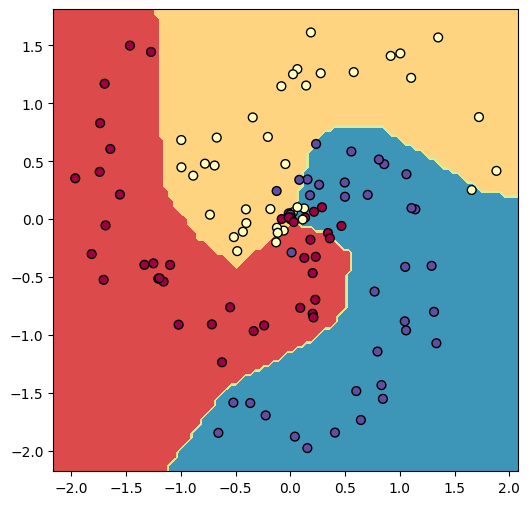

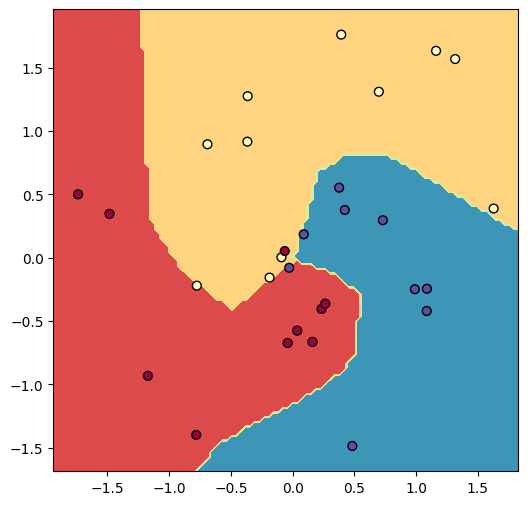


Reg=0 Hidden=30 Activation=ReLU
Train Accuracy: 0.8916666666666667
Val Accuracy: 0.9333333333333333


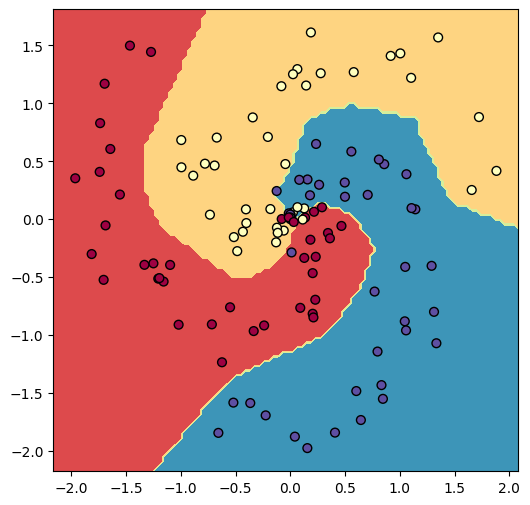

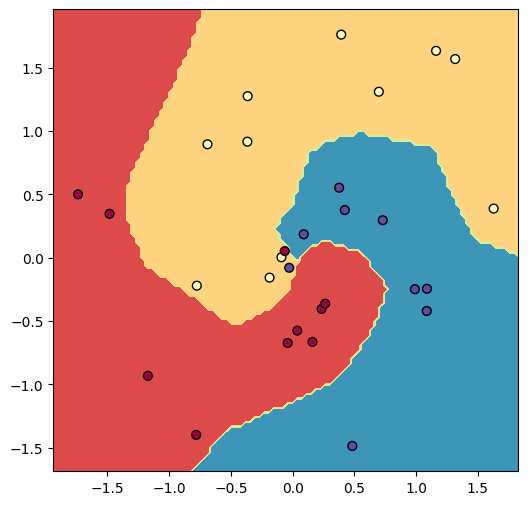


Reg=0.002 Hidden=30 Activation=ReLU
Train Accuracy: 0.8583333333333333
Val Accuracy: 0.9333333333333333


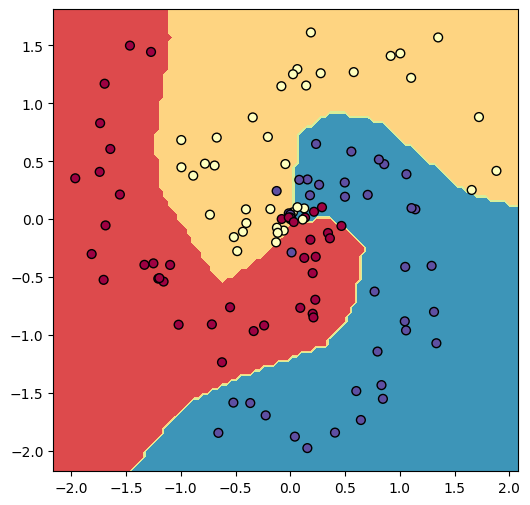

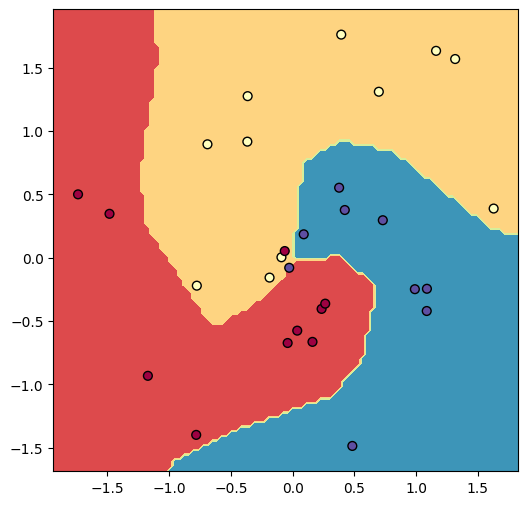


Reg=0.004 Hidden=30 Activation=ReLU
Train Accuracy: 0.825
Val Accuracy: 0.9


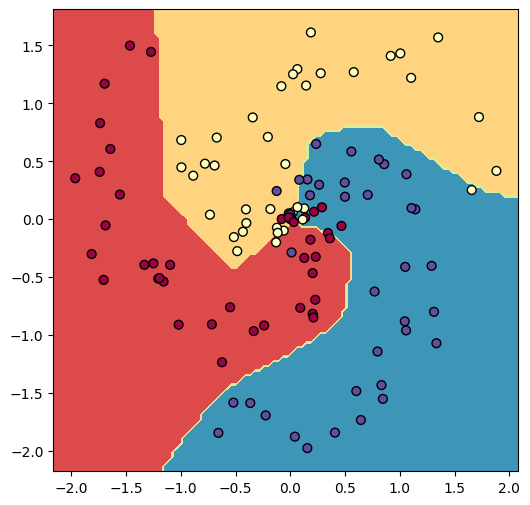

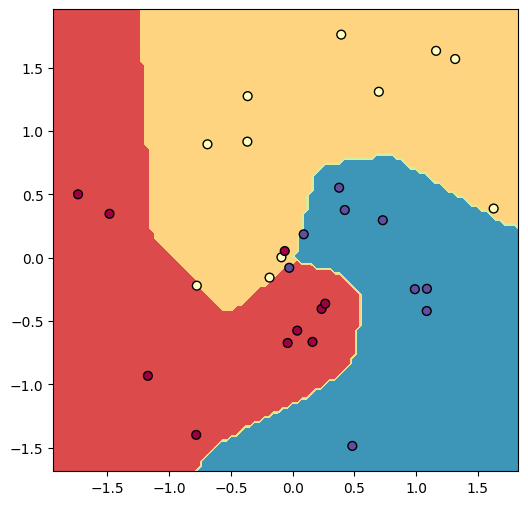

In [ ]:
for activation in ["Sigmoid", "ReLU"]:
  for hidden in [10, 20, 30]:
    for reg in [0, 0.002, 0.004]:
      spiraltwolayer = TwoLayerNeuralNetwork(2,hidden,5,reg=reg,activationfunc=activation)
      train(spiraltwolayer, X_train_spiral, y_train_spiral, optimizer=ADAM(spiraltwolayer), num_epochs=3000, print_every=-1, X_val=X_val_spiral, y_val=y_val_spiral)
      print()
      print("Reg="+str(reg), "Hidden="+str(hidden), "Activation="+str(activation))
      print("Train Accuracy: "+str(np.mean(spiraltwolayer.classify(X_train_spiral) == y_train_spiral)))
      plot_2d_classifier(X_train_spiral, y_train_spiral, spiraltwolayer.classify)
      print("Val Accuracy: "+str(np.mean(spiraltwolayer.classify(X_val_spiral) == y_val_spiral)))
      plot_2d_classifier(X_val_spiral, y_val_spiral, spiraltwolayer.classify)
      plt.show()

# Run on MNIST

In [27]:
#@title MNIST Set Creator
from keras.datasets import mnist
(mnist_t_X, mnist_t_y), (mnist_test_X, mnist_test_y) = mnist.load_data()
mnist_t_X=mnist_t_X.reshape(len(mnist_t_X),784)
mnist_test_X=mnist_test_X.reshape(len(mnist_test_X),784)
indices = np.arange(len(mnist_t_X))
np.random.shuffle(indices)
mnist_train_X, mnist_train_y, mnist_val_X, mnist_val_y = mnist_t_X[indices[:int(0.8*len(indices))]], mnist_t_y[indices[:int(0.8*len(indices))]], mnist_t_X[indices[int(0.8*len(indices)):]], mnist_t_y[indices[int(0.8*len(indices)):]]

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [82]:
#@title Function to Visualize the Weights for MNIST
from matplotlib.colors import TwoSlopeNorm

def visualize_weights(m: LinearClassifier, param='W1'):
    nodes = m.params[param].shape[1]
    fig, axes = plt.subplots(nodes//5, 5, figsize=(15, 3*nodes//5))

    for i, ax in enumerate(axes.flat):
        im = ax.imshow(m.params[param][:,i].reshape(28, 28),
                      cmap='RdBu_r',
                      norm=TwoSlopeNorm(vcenter=0))
        plt.colorbar(im, ax=ax)
        ax.set_title(f'Weights for {i}')
        # Remove axis numbers
        ax.set_xticks([])
        ax.set_yticks([])

    plt.tight_layout()
    plt.show()

In [36]:
#@title Train on MNIST
mnistmodel = TwoLayerNeuralNetwork(784,80,10,reg=0.1, activationfunc="ReLU")
train(mnistmodel,mnist_train_X,mnist_train_y,batch_size=1000,optimizer=ADAM(mnistmodel),X_val=mnist_val_X,y_val=mnist_val_y,save_path="/content/drive/MyDrive/Classroom/Machine Learning 2024-25 TUE + FRI Morn2/utsav_mnist_model.dill")

Epoch 0:
Train Loss = 81.80615406812237
Train Accuracy = 0.11560416666666666
Val Loss = 81.47315453946241
Val Accuracy = 0.11541666666666667
Epoch 1:
Train Loss = 6.173957185984694
Train Accuracy = 0.7464583333333333
Val Loss = 6.201321800721754
Val Accuracy = 0.74375
Epoch 2:
Train Loss = 4.22362660798451
Train Accuracy = 0.8413333333333334
Val Loss = 4.265212181074347
Val Accuracy = 0.83775
Epoch 3:
Train Loss = 3.2677349696504794
Train Accuracy = 0.8728958333333333
Val Loss = 3.3062686554162353
Val Accuracy = 0.86875
Epoch 4:
Train Loss = 2.659639201097666
Train Accuracy = 0.8902708333333333
Val Loss = 2.6932882032363517
Val Accuracy = 0.8843333333333333
Epoch 5:
Train Loss = 2.2035630608351124
Train Accuracy = 0.9124166666666667
Val Loss = 2.2371338937757095
Val Accuracy = 0.9083333333333333
Epoch 6:
Train Loss = 1.8602839717337216
Train Accuracy = 0.9262083333333333
Val Loss = 1.8946968155228947
Val Accuracy = 0.9191666666666667
Epoch 7:
Train Loss = 1.618784873936266
Train Accura

Accuracy: 0.9717


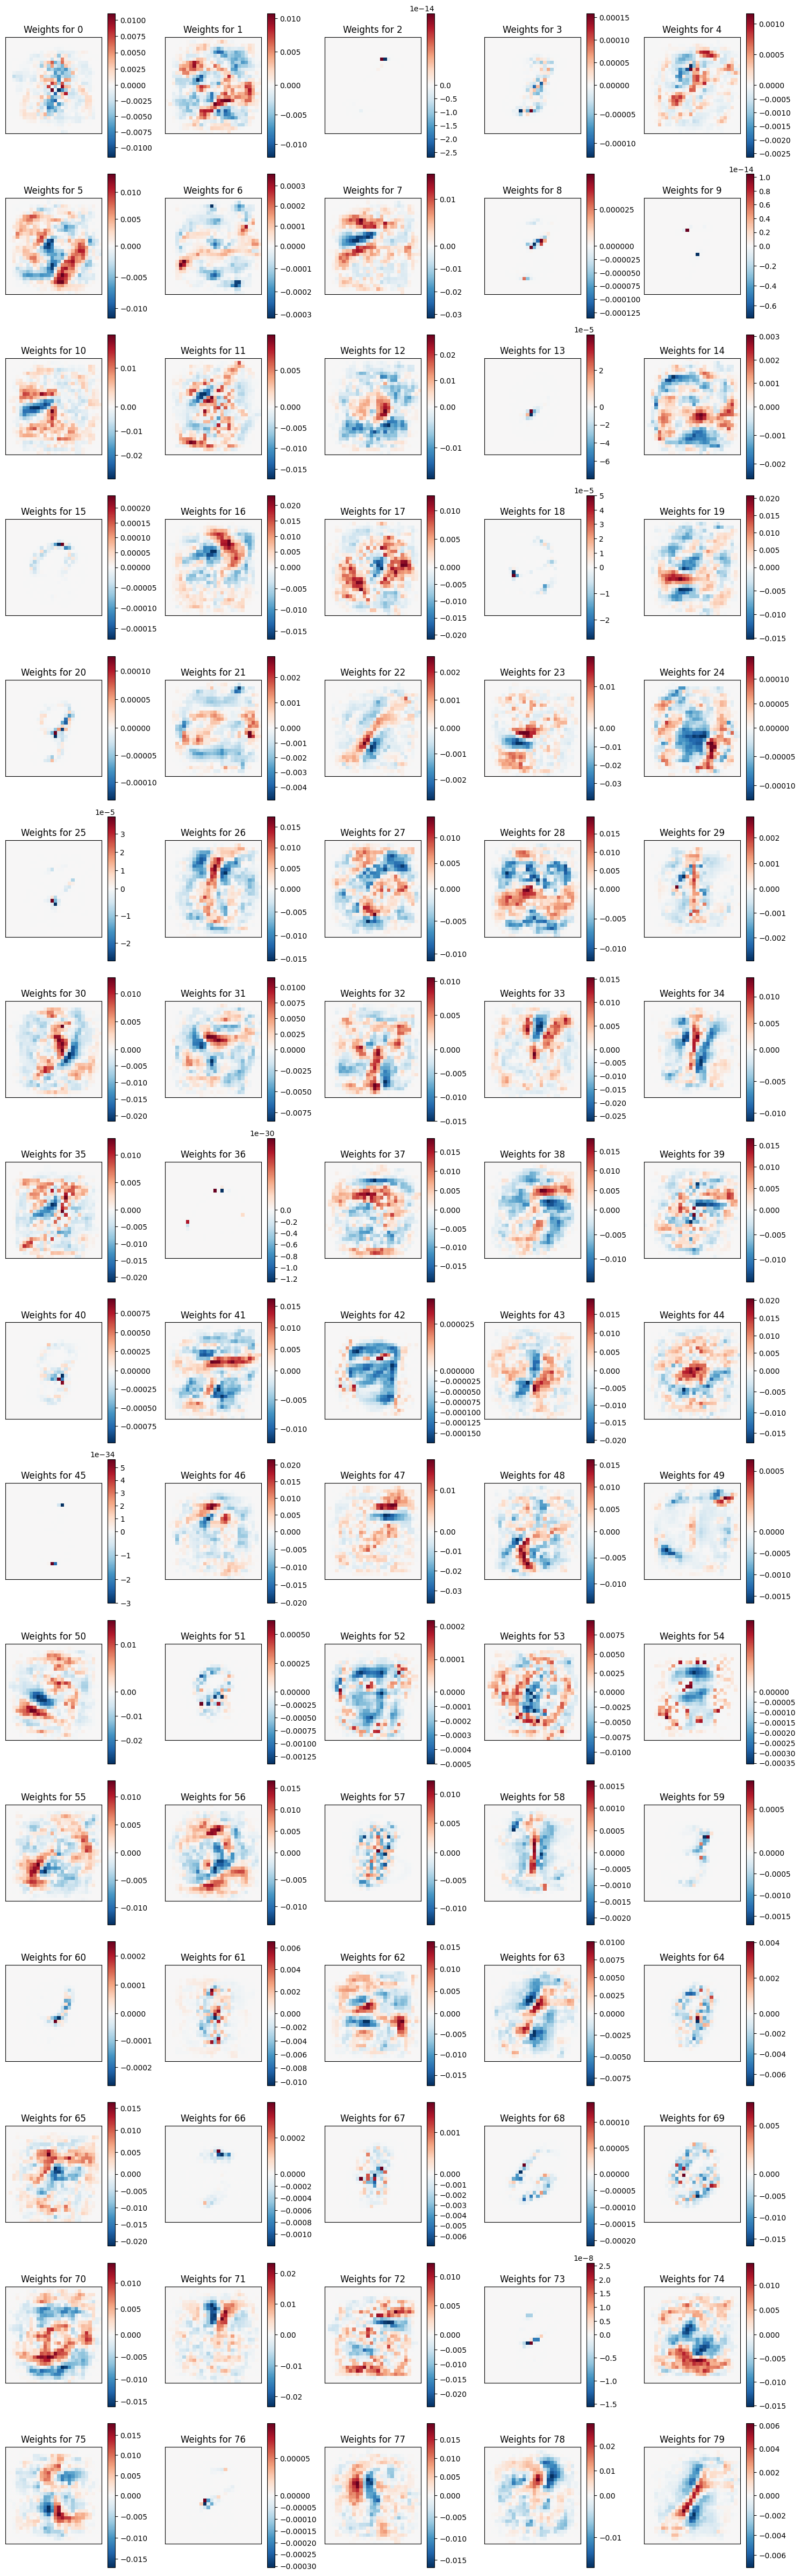

In [83]:
#@title Results for Mnist
print("Accuracy: "+str(np.mean(mnistmodel.classify(mnist_test_X) == mnist_test_y)))
visualize_weights(mnistmodel)

In [59]:
#@title CIFAR Set Creator
from keras.datasets import cifar10
(cifar_t_X, cifar_t_y), (cifar_test_X, cifar_test_y) = cifar10.load_data()
cifar_t_X = cifar_t_X[:10000].astype(float)/256
cifar_t_y = cifar_t_y[:10000]
cifar_t_y = cifar_t_y.reshape(len(cifar_t_y))
cifar_test_y = cifar_test_y[:2000]
cifar_test_X = cifar_test_X[:2000].astype(float)/256
cifar_test_y = cifar_test_y.reshape(len(cifar_test_y))
cifar_t_X=cifar_t_X.reshape(len(cifar_t_X),3072)
cifar_test_X=cifar_test_X.reshape(len(cifar_test_X),3072)
indices = np.arange(len(cifar_t_X))
np.random.shuffle(indices)
cifar_train_X, cifar_train_y, cifar_val_X, cifar_val_y = cifar_t_X[indices[:int(0.8*len(indices))]], cifar_t_y[indices[:int(0.8*len(indices))]], cifar_t_X[indices[int(0.8*len(indices)):]], cifar_t_y[indices[int(0.8*len(indices)):]]

In [76]:
#@title Function to Visualize the Weights for CIFAR
from matplotlib.colors import TwoSlopeNorm

def visualize_weights_cifar(m: LinearClassifier):
    fig, axes = plt.subplots(40, 5, figsize=(15, 120))
    wmin, wmax = np.min(m.params['W1']), np.max(m.params['W1'])
    for i, ax in enumerate(axes.flat):
        im = ax.imshow((m.params['W1'][:,i].reshape(32, 32, 3) - wmin) / (wmax - wmin))
        ax.set_title(f'Weights for '+str(i))
        # Remove axis numbers
        ax.set_xticks([])
        ax.set_yticks([])

    plt.tight_layout()
    plt.show()

In [88]:
#@title CIFAR Model
cifarmodel = TwoLayerNeuralNetwork(3072,200,10,reg=0.001, activationfunc="ReLU")
train(cifarmodel,cifar_train_X,cifar_train_y,num_epochs=50,batch_size=1000,optimizer=ADAM(cifarmodel, 0.0001),X_val=cifar_val_X,y_val=cifar_val_y,save_path="/content/drive/MyDrive/Classroom/Machine Learning 2024-25 TUE + FRI Morn2/utsav_cifar_model.dill")

Epoch 0:
Train Loss = 3.2531542626017442
Train Accuracy = 0.102125
Val Loss = 3.2278900734023184
Val Accuracy = 0.0995
Epoch 1:
Train Loss = 2.5233137092766036
Train Accuracy = 0.1545
Val Loss = 2.4994804397982997
Val Accuracy = 0.1775
Epoch 2:
Train Loss = 2.3395837619061814
Train Accuracy = 0.230625
Val Loss = 2.3444520025722566
Val Accuracy = 0.222
Epoch 3:
Train Loss = 2.2482860473750343
Train Accuracy = 0.266375
Val Loss = 2.236311056388791
Val Accuracy = 0.2795
Epoch 4:
Train Loss = 2.1808362593599795
Train Accuracy = 0.3065
Val Loss = 2.178578524651588
Val Accuracy = 0.2985
Epoch 5:
Train Loss = 2.138459687598779
Train Accuracy = 0.330625
Val Loss = 2.1384864916100605
Val Accuracy = 0.3285
Epoch 6:
Train Loss = 2.112241317450043
Train Accuracy = 0.33075
Val Loss = 2.110815389427553
Val Accuracy = 0.3325
Epoch 7:
Train Loss = 2.085707322047762
Train Accuracy = 0.343375
Val Loss = 2.0887531120317573
Val Accuracy = 0.3455
Epoch 8:
Train Loss = 2.06663630661718
Train Accuracy = 0.35

Accuracy: 0.4045


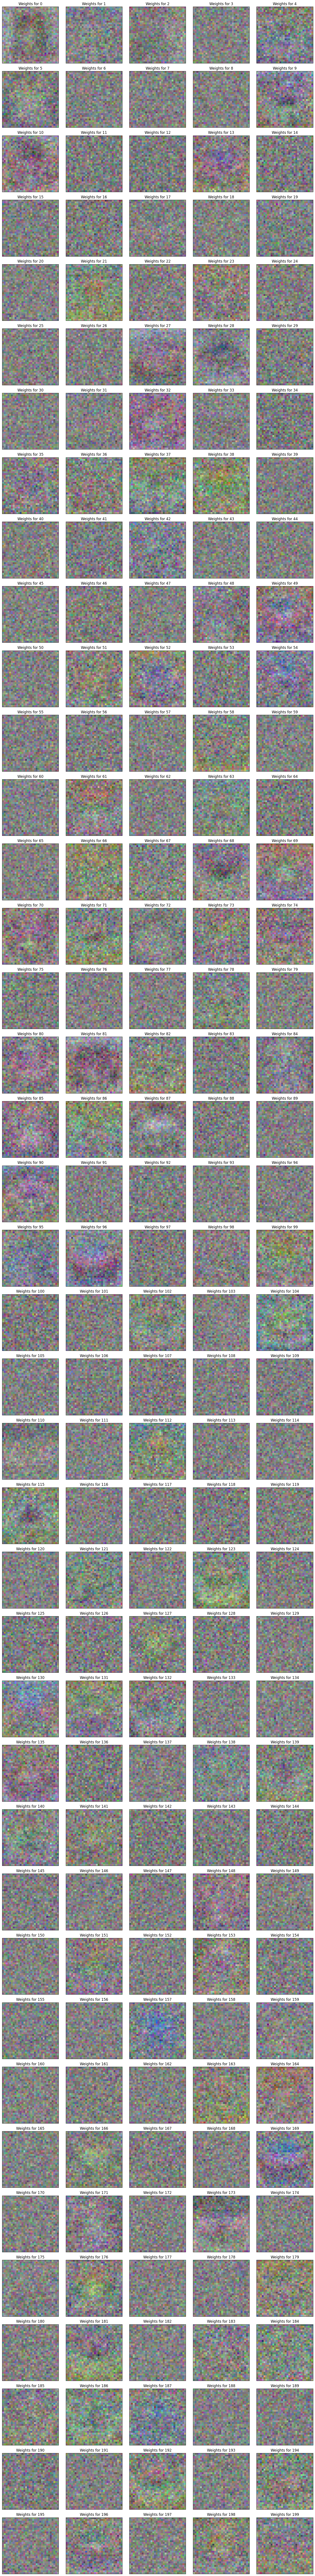

In [89]:
#@title Results for Mnist
print("Accuracy: "+str(np.mean(cifarmodel.classify(cifar_test_X) == cifar_test_y)))
visualize_weights_cifar(cifarmodel)

# Reflection

Jasper for some of the gradients

